<a href="https://colab.research.google.com/github/UmbertoFasci/Multi-output_Model_wrtup/blob/main/EnergyEfficiencyRegression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi-Output TensorFlow Regression

# Imports

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from sklearn.model_selection import train_test_split

# Helper Functions

In [16]:
def format_output(data):
  y1 = data.pop('Y1')
  y1 = np.array(y1)
  y2 = data.pop('Y2')
  y2 = np.array(y2)
  return y1, y2

def norm(x):
  return (x - train_stats['mean']) / train_stats['std']

def plot_diff(y_true, y_pred, title=''):
  plt.scatter(y_true, y_pred)
  plt.title(title)
  plt.xlabel('True Values')
  plt.ylabel('Predictions')
  plt.axis('equal')
  plt.axis('square')
  plt.xlim(plt.xlim())
  plt.ylim(plt.ylim())
  plt.plot([-100, 100], [-100, 100])
  plt.show()

def plot_metrics(metric_name, title, ylim=5):
  plt.title(title)
  plt.ylim(0, ylim)
  plt.plot(history.history[metric_name], color='blue', label=metric_name)
  plt.plot(history.history['val_' + metric_name], color='green', label='val_' + metric_name)

# Prepare The Energy Efficency Data

In [3]:
URI = '/content/ENB2012_data.xlsx'

df = pd.read_excel(URI)
df = df.sample(frac=1).reset_index(drop=True)

train, test = train_test_split(df, test_size=0.2)
train_stats = train.describe()

train_stats.pop('Y1')
train_stats.pop('Y2')
train_stats = train_stats.transpose()
train_y = format_output(train)
test_y = format_output(test)

norm_train_X = norm(train)
norm_test_X = norm(test)

# Build the Model

In [5]:
input_layer = Input(shape=(len(train .columns), ))
first_dense = Dense(128, activation=tf.nn.relu)(input_layer)
second_dense = Dense(128, activation=tf.nn.relu)(first_dense)

y1_output = Dense(1, name='y1_output')(second_dense)
third_dense = Dense(64, activation=tf.nn.relu)(second_dense)

y2_output = Dense(1, name='y2_output')(third_dense)

model = Model(inputs=input_layer, outputs=[y1_output, y2_output])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 8)]          0           []                               
                                                                                                  
 dense_3 (Dense)                (None, 128)          1152        ['input_2[0][0]']                
                                                                                                  
 dense_4 (Dense)                (None, 128)          16512       ['dense_3[0][0]']                
                                                                                                  
 dense_5 (Dense)                (None, 64)           8256        ['dense_4[0][0]']                
                                                                                            

# Model Parameters

In [6]:
model.compile(optimizer = tf.keras.optimizers.SGD(lr=0.001),
              loss = {'y1_output': 'mse', 'y2_output': 'mse'},
              metrics = {'y1_output': tf.keras.metrics.RootMeanSquaredError(),
                        'y2_output': tf.keras.metrics.RootMeanSquaredError()})

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


# Train the Model

In [7]:
history = model.fit(norm_train_X, train_y, epochs=500, batch_size=10, validation_data=(norm_test_X, test_y))

Epoch 1/500
62/62 [==============================] - 2s 7ms/step - loss: 252.2240 - y1_output_loss: 118.8302 - y2_output_loss: 133.3938 - y1_output_root_mean_squared_error: 10.9009 - y2_output_root_mean_squared_error: 11.5496 - val_loss: 69.4395 - val_y1_output_loss: 29.9384 - val_y2_output_loss: 39.5012 - val_y1_output_root_mean_squared_error: 5.4716 - val_y2_output_root_mean_squared_error: 6.2850
Epoch 2/500
62/62 [==============================] - 0s 3ms/step - loss: 32.4377 - y1_output_loss: 12.5273 - y2_output_loss: 19.9104 - y1_output_root_mean_squared_error: 3.5394 - y2_output_root_mean_squared_error: 4.4621 - val_loss: 35.3770 - val_y1_output_loss: 15.7465 - val_y2_output_loss: 19.6305 - val_y1_output_root_mean_squared_error: 3.9682 - val_y2_output_root_mean_squared_error: 4.4306
Epoch 3/500
62/62 [==============================] - 0s 2ms/step - loss: 29.1881 - y1_output_loss: 10.2331 - y2_output_loss: 18.9550 - y1_output_root_mean_squared_error: 3.1989 - y2_output_root_mean_sq

# Model Evaluation

In [11]:
loss, Y1_loss, Y2_loss, Y1_rmse, Y2_rmse = model.evaluate(x=norm_test_X, y=test_y)
print("Loss = {}, Y1_loss = {}, Y1_rmse = {}, Y2_loss = {}, Y2_rmse = {}".format(loss, Y1_loss, Y1_rmse, Y2_loss, Y2_rmse))

5/5 [==============================] - 0s 5ms/step - loss: 1.7007 - y1_output_loss: 0.2615 - y2_output_loss: 1.4392 - y1_output_root_mean_squared_error: 0.5114 - y2_output_root_mean_squared_error: 1.1997
Loss = 1.7007343769073486, Y1_loss = 0.26154547929763794, Y1_rmse = 0.5114151835441589, Y2_loss = 1.4391887187957764, Y2_rmse = 1.1996619701385498


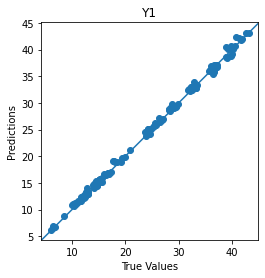

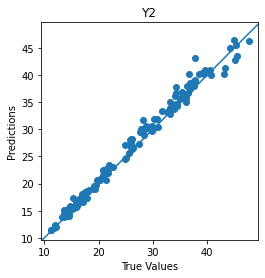

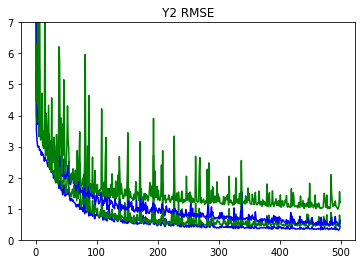

In [18]:
Y_pred = model.predict(norm_test_X)
plot_diff(test_y[0], Y_pred[0], title='Y1')
plot_diff(test_y[1], Y_pred[1], title='Y2')
plot_metrics(metric_name='y1_output_root_mean_squared_error', title='Y1 RMSE', ylim=6)
plot_metrics(metric_name='y2_output_root_mean_squared_error', title='Y2 RMSE', ylim=7)